# Data Visualizing

# Environmental Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

COUNTRY_MAP = {'Azerbaijan': 'AZ', 'Korea': 'KR', 'Myanmar': 'MM', 'UK': 'UK', 'US': 'US'}
MODEL_MAP = {"glm4v": "GLM4-v-Plus", "internVL": "InternVL2.5-26B", "gpt4o": "GPT-4o"}
CATEGORY_MAP = {"Clothes": "Clot", "Festival": "Fest", "Food": "Food"}
MODELS = ["gpt4o", "glm4v", "internVL"]
CATEGORIES = ["Clothes", "Festival", "Food"]
    # Add red borders to specific cells
HIGHLIGHT_CELLS = {"UK": "Caucasian", "MM": "East Asian", "KR": "East Asian"}

In [ ]:
def load_cultural_data(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Prepare the data dictionary to include model-specific data
    data = {}

    # Loop through each row and structure the data
    for _, row in df.iterrows():
        country_race = row["Country-Race"].split("-")
        country = country_race[0]
        race = country_race[1] if len(country_race) > 1 else None

        # if race is written in camel case, separate it with a space
        race = ''.join(' ' + c if c.isupper() else c for c in race).strip()

        if country not in data:
            data[country] = {}

        for col in df.columns[1:]:  # Exclude "Country-Race"
            if pd.notna(row[col]):  # Skip NaN values
                model, category = col.split("-")
                if model not in data[country]:
                    data[country][model] = {}
                if category not in data[country][model]:
                    data[country][model][category] = {}
                data[country][model][category][race] = row[col]
    return data

def load_food_data(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Preparing the nested dictionary
    data = {}
    for _, row in df.iterrows():
        country, race = row['Country-Race'].split('-')
        for model in MODELS:
            data.setdefault(model, {}).setdefault(country, {})[race] = row[model]
    return data

# Plotting Functions

## Cultural Identification

### Bar Chart (Average)

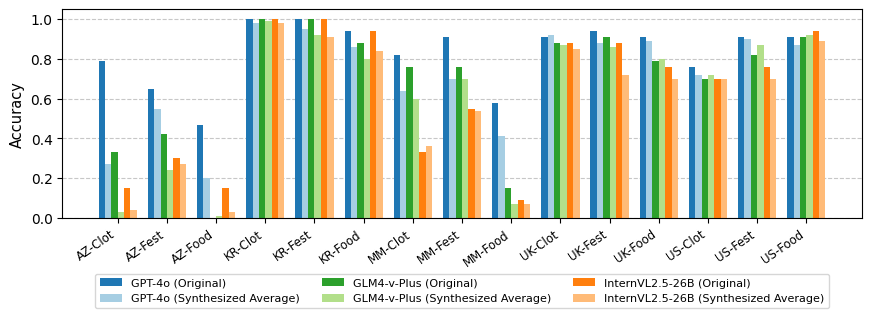

In [ ]:
data = load_cultural_data("responses/cultural_accuracy_bar.csv")

races = ['Original', 'Average']
race_map = {'Original': 'Original', 'Average': 'Synthesized Average'}
colors = {
    'gpt4o': {'Original': '#2ca02c', 'Average': '#b2df8a'},
    'glm4v': {'Original': '#1f77b4', 'Average': '#a6cee3'},
    'internVL': {'Original': '#ff7f0e', 'Average': '#ffbb78'}
}


label_font_size = 8.5

# Create figure
fig, ax = plt.subplots(figsize=(9, 3.5))

# Calculate positions
n_groups = len(data) * len(CATEGORIES)  # Number of country-category combinations
group_width = 0.7  # Average width for each group
bar_width = group_width / (len(MODELS) * len(races))  # Width of each bar
group_positions = np.arange(n_groups) * (group_width + 0.2)  # Add more space between groups


# Plot bars
for i, model in enumerate(MODELS):
    for j, race in enumerate(races):
        heights = []
        labels = []
        
        for country in data.keys():
            for category in CATEGORIES:
                heights.append(data[country].get(model, {}).get(category, {}).get(race, 0))
                labels.append(f"{COUNTRY_MAP[country]}-{CATEGORY_MAP[category]}")
        
        x = group_positions + (i * len(races) + j) * bar_width
        bars = ax.bar(
            x,
            heights,
            bar_width,
            label=f'{MODEL_MAP[model]} ({race_map[race]})',
            color=colors[model][race]
        )

# Customize plot
ax.set_ylabel('Accuracy', fontsize=label_font_size+2)

# Set x-axis ticks in the middle of each group
ax.set_xticks(group_positions + (group_width / 2) - (bar_width / 2))
ax.set_xticklabels(labels, rotation=35, ha='right', fontsize=label_font_size)

# Add grid for easier comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Reorder legend handles and labels to group models together
handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[0], handles[1], handles[2], handles[3], handles[4], handles[5]]
new_labels = [labels[0], labels[1], labels[2], labels[3], labels[4], labels[5]]

# Adjust legend to have 2 rows and 3 columns
ax.legend(new_handles, new_labels, bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3, fontsize=8)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save and show the figure
plt.savefig("Assets/cultural_accuracy_barchart_average.png", bbox_inches='tight', dpi=300)
plt.show()

### Bar Chart (Comprehensive)

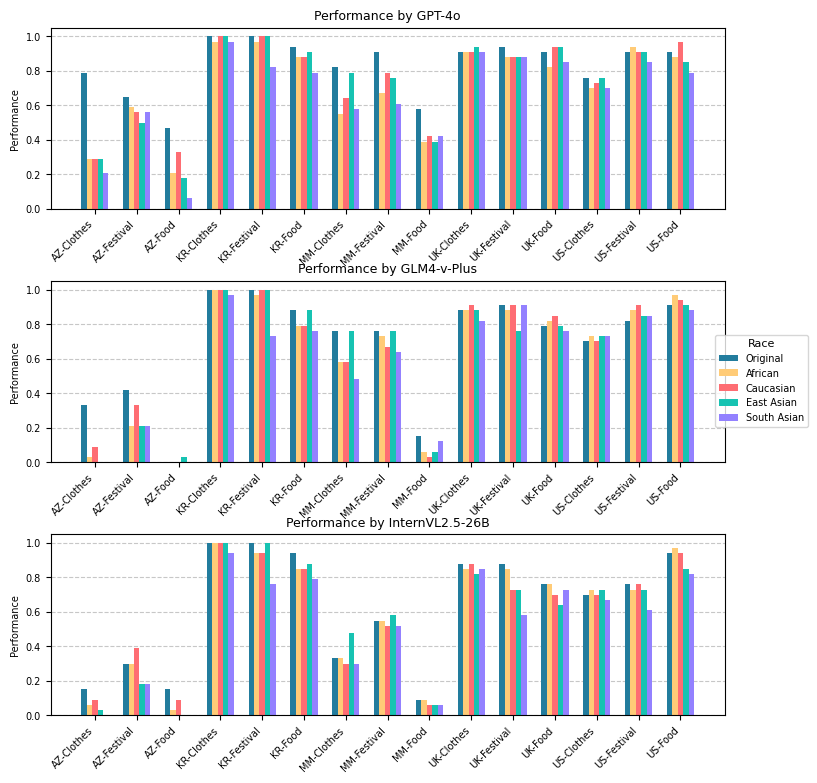

In [20]:
data = load_cultural_data("responses/cultural_accuracy_bar.csv")

races = ["Original", 'African', 'Caucasian', 'East Asian', 'South Asian']
race_colors = {"Original": "#227c9d", "East Asian": "#17c3b2", "African": "#ffcb77", "South Asian": "#9381ff", "Caucasian": "#fe6d73"}

# Create one figure with three subplots vertically
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
fig.tight_layout(pad=3.0)  # Add some padding between subplots
label_font_size = 7
# Loop through models and corresponding axes
for ax_idx, (model, ax) in enumerate(zip(MODELS, axes)):
    x = np.arange(len(data) * len(CATEGORIES))
    width = 0.13

    bar_offsets = []
    for i, race in enumerate(races):
        offsets = width * i
        heights = []
        labels = []

        for country in data.keys():
            for category in CATEGORIES:
                heights.append(data[country].get(model, {}).get(category, {}).get(race, 0))
                labels.append(f"{COUNTRY_MAP[country]}-{category}")

        bar_offsets.append(x + offsets)
        bars = ax.bar(
            x + offsets, 
            heights, 
            width, 
            label=race, 
            color=race_colors.get(race, "#cccccc")
        )

    # Set title for each subplot
    ax.set_title(f"Performance by {MODEL_MAP[model]}", fontsize=label_font_size+2)
    
    # Only show x-axis labels for the bottom subplot
    ax.set_xticks(x + width * (len(races) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=label_font_size)    
    ax.set_ylabel("Performance", fontsize=label_font_size)
    ax.tick_params(axis='y', labelsize=label_font_size)  

    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

# Adjust layout to make more space between subplots
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots

# Create a single legend for the entire figureGet handles and labels from the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
# For legend
fig.legend(handles, labels, title="Race", 
          loc='center', bbox_to_anchor=(0.98, 0.5),
          fontsize=label_font_size,  # For legend labels
          title_fontsize=label_font_size+1)  # For legend title

# Save and show the figure
plt.savefig("Assets/cultural_accuracy_barchart.png", 
            bbox_inches='tight',  # Ensure the legend isn't cut off
            dpi=300)             # Higher resolution
plt.show()

### Heatmap

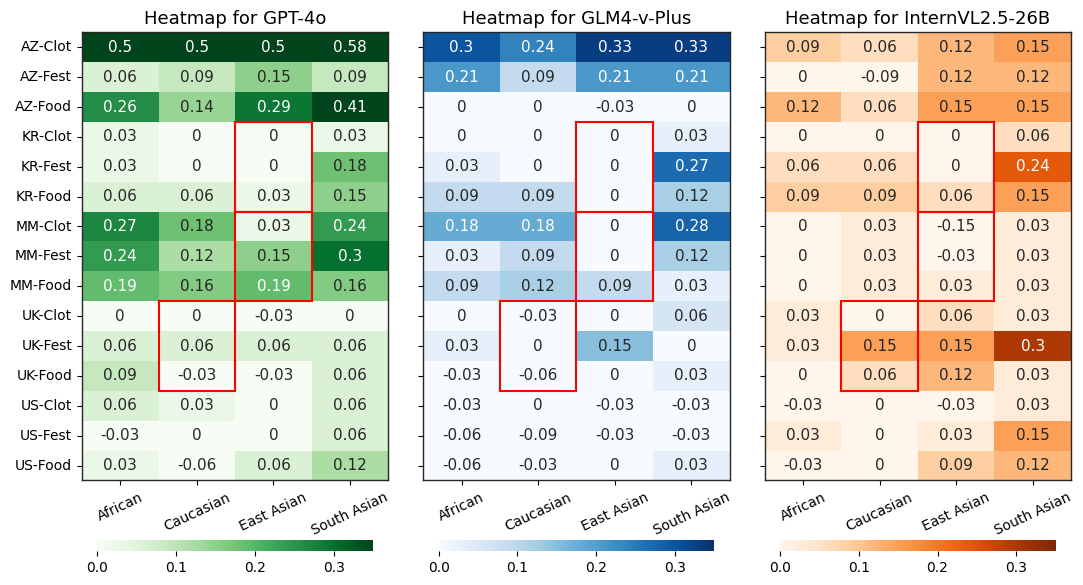

In [4]:
data = load_cultural_data("responses/cultural_accuracy_heatmap.csv")

label_font_size = 10
race_order = ["Original", "African", "Caucasian", "East Asian", "South Asian"]
cmaps = ["Greens", "Blues", "Oranges"]  # Custom sequential colormaps

def prepare_heatmap_data(model):
    countries = []
    races = []
    values = []
    
    for country, models in data.items():
        for category, metrics in models[model].items():
            for race, value in metrics.items():
                countries.append(f"{COUNTRY_MAP[country]}-{CATEGORY_MAP[category]}")
                races.append(race)
                values.append(value)
    
    df = pd.DataFrame({'Country-Category': countries, 'Race': races, 'Value': values})
    pivot_df = df.pivot(index='Country-Category', columns='Race', values='Value')
    
    # Remove "Original" column
    pivot_df = pivot_df.drop(columns=["Original"], errors='ignore')
    
    return pivot_df.reindex(columns=[r for r in race_order if r != "Original"])

# Create subplots
fig, axes = plt.subplots(1, len(MODELS), figsize=(11, 6.5), sharey=True)  # Shared y-axis

# Generate heatmaps
for i, (model, cmap) in enumerate(zip(MODELS, cmaps)):
    heatmap_data = prepare_heatmap_data(model)

    ax = axes[i]
    sns.heatmap(
        heatmap_data,
        annot=True,
        ax=ax,
        cmap=cmap,  
        cbar=True,
        vmin=0.0,
        vmax=0.35,
        annot_kws={"fontsize": label_font_size+1},
        cbar_kws={"orientation": "horizontal", "pad": 0.1, "aspect":25, "shrink":0.9},
    )

    ax.set_title(f"Heatmap for {MODEL_MAP[model]}", fontsize=label_font_size+3)
    ax.tick_params(axis='both', which='major', labelsize=label_font_size)
    ax.tick_params(axis='x', rotation=25)

    # Remove axis labels but keep tick values
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Move color bar below
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([ax.get_position().x0, ax.get_position().y0 - 0.08, ax.get_position().width, 0.1])

    # Add black border around each heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("#262625")

    for y, row_label in enumerate(heatmap_data.index):
        country, category = row_label.split("-")
        for x, col_label in enumerate(heatmap_data.columns):
            if HIGHLIGHT_CELLS.get(country) == col_label:
                left, top = x, y
                right, bottom = left + 1, top + 1
                
                # Draw only vertical borders and specific horizontal borders
                # Draw vertical borders for all cells
                ax.plot([left, left], [top, bottom], color="red", linewidth=1.5)
                ax.plot([right, right], [top, bottom], color="red", linewidth=1.5)
                
                # Draw horizontal borders only for specific cases
                if category == CATEGORY_MAP["Clothes"]:
                    # Draw only bottom border for Clothes
                    ax.plot([left, right], [top, top], color="red", linewidth=1.5)
                elif category == CATEGORY_MAP["Food"]:
                    # Draw only top border for Food
                    ax.plot([left, right], [bottom, bottom], color="red", linewidth=1.5)
                # Festival category will have no horizontal borders


# Adjust y-axis (only first subplot shows labels)
for ax in axes[1:]:
    ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Assets/cultural_accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


## Food Identification

In [5]:
def load_food_data(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Preparing the nested dictionary
    data = {}
    for _, row in df.iterrows():
        country, race = row['Country-Race'].split('-')
        for model in MODELS:
            data.setdefault(model, {}).setdefault(country, {})[race] = row[model]
    return data

### Bar Chart

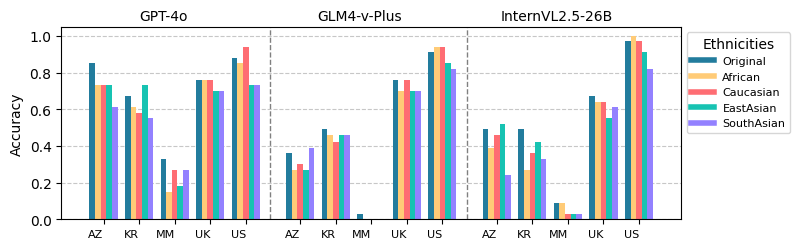

In [11]:
import numpy as np
import matplotlib.pyplot as plt

data = load_food_data('responses/food_label_accuracy_bar.csv')
races = ["Original", 'African', 'Caucasian', 'EastAsian', 'SouthAsian']
race_colors = ['#227c9d', '#ffcb77', '#fe6d73', '#17c3b2', '#9381ff']

label_font_size = 8
fig, ax = plt.subplots(figsize=(8, 2.5))
bar_width = 0.15
num_models = len(data)
num_countries = len(next(iter(data.values())))
group_spacing = 0.2
model_spacing = 0.5

# Generate positions
num_groups = num_models * num_countries
group_positions = (np.arange(num_groups) * (bar_width * len(races) + group_spacing) + 
    np.repeat(np.arange(num_models) * model_spacing, num_countries)
)
labels = [COUNTRY_MAP[country] for model in data for country in data[model]]

# Plot bars
for model_idx, (model, countries) in enumerate(data.items()):
    for country_idx, (country, values) in enumerate(countries.items()):
        bar_positions = group_positions[model_idx * num_countries + country_idx] + np.arange(len(races)) * bar_width
        ax.bar(bar_positions, [values[race] for race in races], bar_width, color=race_colors)

# Set ticks and labels
ax.set_xticks(group_positions + (len(races)-1) * bar_width / 2)
ax.set_xticklabels(labels, ha='right', fontsize=label_font_size)
ax.set_ylabel('Accuracy', fontsize=label_font_size + 2)

# Custom legend
custom_legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in race_colors]
ax.legend(custom_legend_handles, races, title="Ethnicities", bbox_to_anchor=(1, 1), loc='upper left', fontsize=label_font_size)


# Add grid for easier comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add vertical separators and subtitles
for i in range(1, num_models):
    separator = group_positions[i * num_countries - 1] + bar_width * len(races) + group_spacing
    ax.axvline(x=separator, color='gray', linestyle='--', linewidth=1)

# Add subtitles for models
for i, model in enumerate(MODELS):
    start_idx = i * num_countries
    end_idx = (i + 1) * num_countries - 1
    mid_pos = (group_positions[start_idx] + group_positions[end_idx]) / 2
    ax.text(mid_pos, 1.07, MODEL_MAP[model], ha='center', va='bottom', fontsize=label_font_size + 2)

plt.savefig("Assets/foodlabel_accuracy_barchart.png", bbox_inches='tight', dpi=300)
plt.show()


### Heatmap

/tmp/ipykernel_174003/1575797944.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


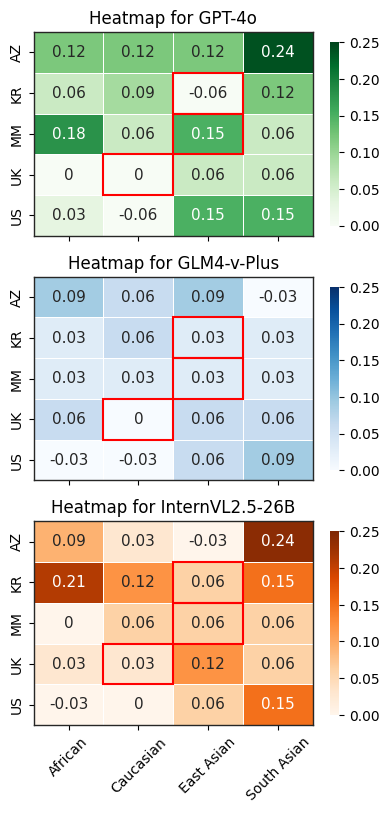

In [5]:
# Load data
data = load_food_data('responses/food_label_accuracy_heatmap.csv')

label_font_size = 10
race_order = ["Original", "African", "Caucasian", "East Asian", "South Asian"]
race_map = {
    "Original": "Original", 
    "EastAsian": "East Asian", 
    "African": "African", 
    "SouthAsian": "South Asian", 
    "Caucasian": "Caucasian"
}
cmaps = ["Greens", "Blues", "Oranges"]  # Custom colormaps for each model

# Prepare data for heatmap
def prepare_heatmap_data(model):
    rows = []
    for country, values in data[model].items():
        for race, value in values.items():
            if race != "Total":  # Exclude 'Total'
                rows.append({
                    "Country": COUNTRY_MAP[country],  # Map country names
                    "Race": race_map[race], 
                    "Value": value
                })
    
    df = pd.DataFrame(rows)
    
    pivot_df = df.pivot(index="Country", columns="Race", values="Value").reindex(columns=race_order)
    # Remove "Original" column
    pivot_df = pivot_df.drop(columns=["Original"], errors='ignore')
    
    return pivot_df.reindex(columns=[r for r in race_order if r != "Original"])

# Create subplots stacked vertically
fig, axes = plt.subplots(len(MODELS), 1, figsize=(4.5, 9), sharex=True, gridspec_kw={'hspace': 0.2})  

# Generate heatmaps
for i, (model, cmap) in enumerate(zip(MODELS, cmaps)):
    heatmap_data = prepare_heatmap_data(model)
    
    ax = axes[i]
    sns.heatmap(
        heatmap_data,
        annot=True,
        ax=ax,
        cmap=cmap,  # Different cmap for each model
        cbar=True,
        vmin=0.0,
        vmax=0.25,
        linewidths=0.5,  # Subtle inner grid lines
        annot_kws={"fontsize": label_font_size+1},
        cbar_kws={"shrink": 0.9, "aspect": 20}  # Keep color bar on the right, shrink slightly
    )

    ax.set_title(f"Heatmap for {MODEL_MAP[model]}", fontsize=label_font_size+2)
    ax.tick_params(axis='both', which='major', labelsize=label_font_size)
    ax.tick_params(axis='x', rotation=45)

    # Remove axis labels but keep tick values
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add black border around each heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)  # Ensure borders are visible
        spine.set_linewidth(1)  # Make them thicker
        spine.set_color("#262625")  # Set to black

    for y, country in enumerate(heatmap_data.index):
        for x, col_label in enumerate(heatmap_data.columns):
            if HIGHLIGHT_CELLS.get(country) == col_label:
                # draw red borders around the cell
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1.5))
                

plt.tight_layout()
plt.savefig("Assets/foodlabel_accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
